<div style="color:#8b1538; font-size:28px">Ce jupyter notebook permet la manipulation de fichier PDB en python</div>

- Lecture de fichier .pdb
- Visualisation de structures
- Alignement de séquences
- Comparaison de deux structures: alignement & rmsd
- Carte de contact (contact maps) - calcul et affichage

Il utilise les fonctions mise en place dans le module **prot_py** codé en python (version 3.7.8).

Il est également réalisé dans ce jupyter notebook:

- La génération des sous-structures pour le benchhmark
- La lecture des fichiers **benchmark-python.json** & **benchmark-julia.txt** situés dans le dossier ./data
- Génération des graphiques de comparaison de performance entre python & julia

<br>

# Les modules

In [1]:
%%capture

import json
import os
import re
import resource
import time

import Bio.PDB as PDB
import matplotlib.pyplot as plt
import numpy as np
import nglview as nv
import pandas as pd
import pytraj as pt
import seaborn as sns

from prot_py.alignment import alignment as ali
from prot_py.arguments import arguments as arg
from prot_py.files import files as f
from prot_py.maps import maps

<br>

# Téléchargement & chargement des structures

In [2]:
%%capture
pdb = ["1A01", "2QSP"]
f.fetch_pdb(pdb)
struct = f.load_pdb(pdb)

<br>

# Visualisation

## 1A01 - hémoglobine humaine

In [3]:
traj = pt.iterload('./data/pdb/{}.pdb'.format(pdb[0]))
view = nv.show_pytraj(traj)
view

NGLWidget()

## 2QSP - hémoglobine bovine

In [4]:
traj = pt.iterload('./data/pdb/{}.pdb'.format(pdb[1]))
view = nv.show_pytraj(traj)
view

NGLWidget()

<br>

# Alignement de séquences

Paramètre de l'alignement:

- **global** - alignement global des deux protéines
- **region** - alignement global des régions

In [5]:
align_param = "global"
alignment = ali.sequences_alignment(struct, align_param)

Alignement global des séquences de 1A01 & 2QSP


In [6]:
ali.print_alignment(alignment)

VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYRMHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPATQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYHVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYRMHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPATQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH
|||.|||.||||||||||.||.|||||||||||||||||||||||||||||||||||||.|||.|||.||.|.||.|.|||.|||||||||||||||||||||.||||||.|||..||||||||||||||.||||||||||| ||.|||.||||.||||.|||||||||||||||||.|||||||||||||.||||.||||||||||||..||.|..|||.||||||.||||||||||||||||.|||||||.|||..|||||||..||..|||||||||||||.|||||.|||.||||||||||.||.|||||||||||||||||||||||||||||||||||||.|||.|||.||.|.||.|.|||.|||||||||||||||||||||.||||||.|||..||||||||||||||.|||||||

In [6]:
align_param = "region"
alignments = ali.sequences_alignment(struct, align_param)

Alignement region des séquences de 1A01 & 2QSP


In [7]:
for align in alignments:
    ali.print_alignment(align)

VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
|||.|||.||||||||||.||.|||||||||||||||||||||||||||||||||||||.|||.|||.||.|.||.|.|||.|||||||||||||||||||||.||||||.|||..||||||||||||||.||||||||||
VLSAADKGNVKAAWGKVGGHAAEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGAKVAAALTKAVEHLDDLPGALSELSDLHAHKLRVDPVNFKLLSHSLLVTLASHLPSDFTPAVHASLDKFLANVSTVLTSKYR
  Score=639

MHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPATQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH
| ||.|||.||||.||||.|||||||||||||||||.|||||||||||||.||||.||||||||||||..||.|..|||.||||||.||||||||||||||||.|||||||.|||..|||||||..||..|||||||||||||.||
M-LTAEEKAAVTAFWGKVKVDEVGGEALGRLLVVYPWTQRFFESFGDLSTADAVMNNPKVKAHGKKVLDSFSNGMKHLDDLKGTFAALSELHCDKLHVDPENFKLLGNVLVVVLARNFGKEFTPVLQADFQKVVAGVANALAHRYH
  Score=624

VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLV

# Alignement des structures & RMSD

In [10]:
rmsd, aligned_struct = ali.structures_alignment(struct)

Alignement des structures de 1A01 & 2QSP


In [11]:
print("Le rmsd vaut {:.3f} Angstom".format(rmsd))

Le rmsd vaut 2.918 Angstom


In [12]:
view = nv.show_biopython(aligned_struct)
view

NGLWidget()

# Carte de contacts

In [13]:
def plot_contact_map(contact_map, pdb, cutoff):
    """
    Génère le graphe d'une carte de contacts donnée.
    """
    fig, axs = plt.subplots(1, 1, figsize=(12, 10), constrained_layout=True)
    axs.imshow(contact_map, aspect="auto", cmap=plt.cm.gray, interpolation='nearest')

    title = "Carte de contacts de la protéine {} pour un cutoff de {}A".format(pdb, cutoff)
    fig.suptitle(title, fontsize="xx-large")

    plt.show()
    plt.clf()

In [14]:
cutoff = 8
contact_map = maps.compute_contact_map(struct[0], struct[0].id, cutoff)

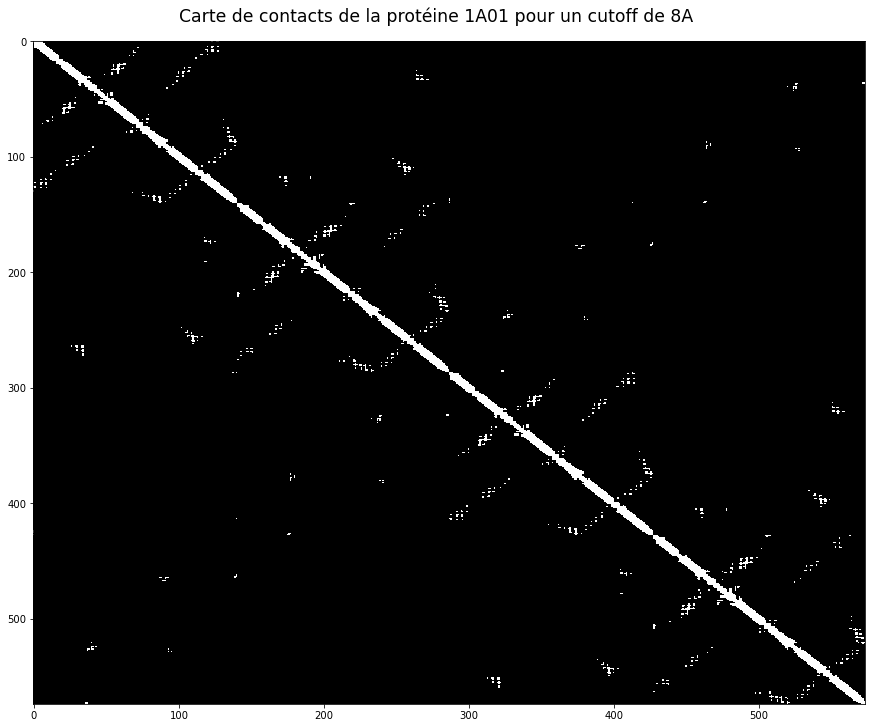

<Figure size 432x288 with 0 Axes>

In [15]:
plot_contact_map(contact_map, struct[0].id, cutoff)

<br>

In [16]:
cutoff = 8
contact_map = maps.compute_contact_map(struct[1], pdb[1], cutoff)

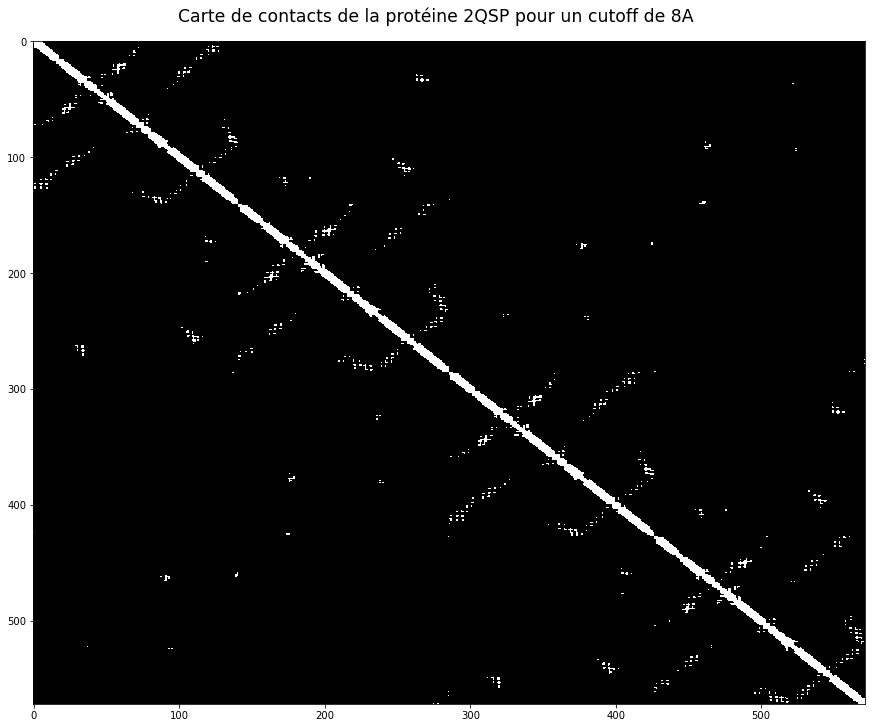

<Figure size 432x288 with 0 Axes>

In [17]:
plot_contact_map(contact_map, pdb[1], cutoff)

<br>

# 2G33

Capside du virus de l'hépatite B (HBV) avec T=4, i.e. la capside de HBV est constitué de 240 monomère de HBc soit 120 dimères.

La structure de la macromolécule a été obtenue par x-ray diffraction et a une résolution de 3.96A.

La macromolécule est constituée de 588 résidues & 4658 atomes.

In [17]:
%%capture
pdb = ["2G33"]
f.fetch_pdb(pdb)
struct = f.load_pdb(pdb)

<br>

## Visualisation

In [18]:
traj = pt.iterload('./data/pdb/{}.pdb'.format(pdb[0]))
view = nv.show_pytraj(traj)
view

NGLWidget()

<br>

## Carte de contacts

In [22]:
cutoff = 10
contact_map = maps.compute_contact_map(struct[0], pdb[0], cutoff)

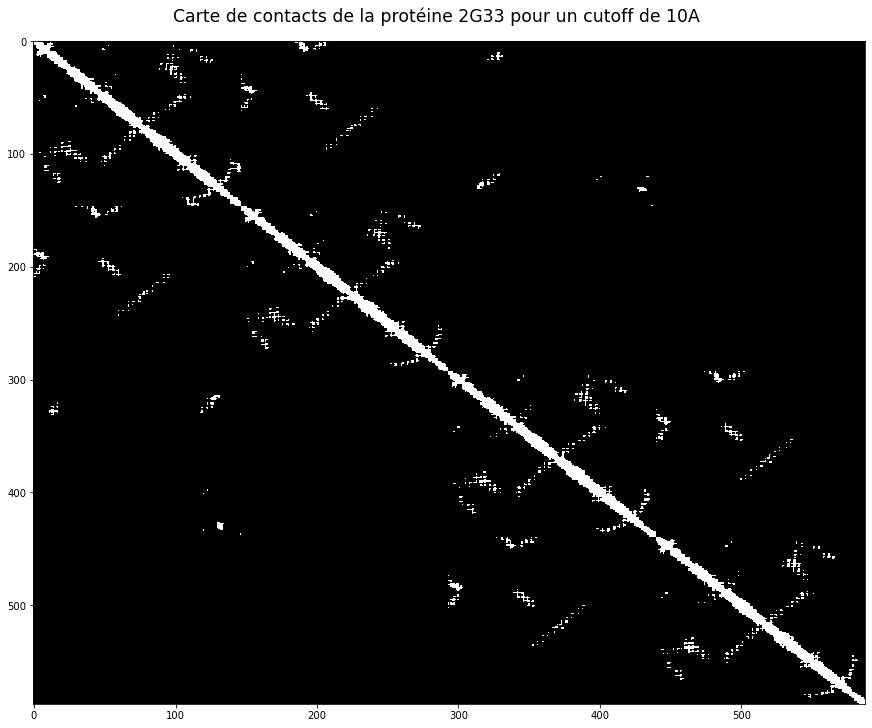

<Figure size 432x288 with 0 Axes>

In [23]:
plot_contact_map(contact_map, pdb[0], cutoff)

# 1HTQ

Structure cristallographique multicopie d'une glutamine synthétase détendue.

La structure de la macromolécule a été obtenu par x-ray diffraction et a une résolution de 2.40A.

L'assemblage est constitué de 11 448 résidues & 97 872 atomes.

In [24]:
%%capture
pdb = ["1HTQ"]
f.fetch_pdb(pdb)
struct = f.load_pdb(pdb)

<br>

## Visualisation

In [25]:
traj = pt.iterload('./data/pdb/{}.pdb'.format(pdb[0]))
view = nv.show_pytraj(traj)
view

NGLWidget(max_frame=9)

# Carte de contacts

In [71]:
cutoff = 8
contact_map = maps.compute_contact_map(struct[0], pdb[0], cutoff)

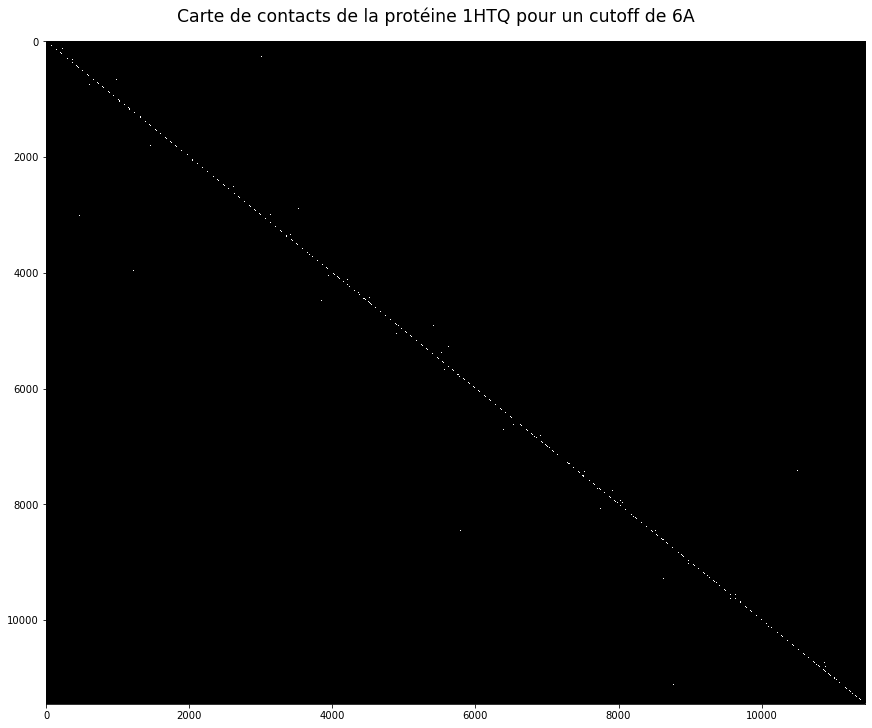

<Figure size 432x288 with 0 Axes>

In [72]:
plot_contact_map(contact_map, pdb[0], cutoff)

<br>

<br>

# Générer les structures pour le benchmark

In [30]:
def read_structure(struct):
    """
    Sélectionne pour une structure donnée l'ensemble des éléments 
    """
    data = []
    with open("./data/pdb/{}.pdb".format(struct.id), "r") as filin:
        lines = filin.readlines()
        for line in lines:
            if line.startswith('ATOM') or line.startswith('TER'):
                data.append(line)
            if line.startswith('ENDMDL'):
                return data
    return data


def create_substructure(struct):
    """
    
    """
    subchain = [
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 
        'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X'
    ]
    
    data = read_structure(struct)
    
    for i in range(20):
        with open("./data/pdb/Benchmark/{}_{}.pdb".format(struct.id, i+1), "w") as filout:
            
            # Ecrire i copie de la structure dans le fichier pdb
            for j in range(i+1):
                for line in data:
                    line = line[:21] + subchain[j] + line[22:]  # Mettre à jour la chaîne des sous-structures
                    filout.write(line)
                    
            filout.write("END" + " " * 77 + "\n")

In [31]:
%%capture
pdb = ["1CRN"]
f.fetch_pdb(pdb)
struct = f.load_pdb(pdb)
create_substructure(struct[0])

<br>

# Benchmark

In [65]:
def duplicate(data, key):
    if key == 'Residues':
        return [ele*0.110 for ele in data for _ in range(100)]  # Détermine la masse de la protéine en kDa
    return [np.log10(ele) for ele in data for _ in range(100)]  # Détermine le log base 10


def dico_to_dataframe(dico):
    series = []
    
    for key, value in dico.items():
        
        if key == 'Alignement seq':
            for k, v in value.items():
                v = [duplicate(sublist, key) if len(sublist) == 1 else np.log10(sublist) for sublist in v]
                series.append(pd.Series([ele for sublist in v for ele in sublist], name="{} {}".format(key, k)))
        
        elif key == 'Residues':
            series.append(pd.Series(duplicate(value, key), name="Masse protéine - kDa"))
                       
        else:
            series.append(pd.Series([np.log10(ele) for sublist in value for ele in sublist], name=key))
        
    return pd.concat(series, axis=1)

> Exporter benchmark-python.json dans un pandas DataFrame

In [66]:
def python_benchmark_to_df():
    dico = {}
    
    # Opening JSON file 
    with open("./data/benchmark-python.json") as json_file: 
        data = json.load(json_file) 
          
    for key in data.keys():
        dico[key] = data[key]['0']
        
    return dico_to_dataframe(dico)

data_python = python_benchmark_to_df()

> Exporter benchmark-julia.txt dans un pandas DataFrame

In [67]:
def julia_benchmark_to_df():
    dico = {}
    
    with open("./data/benchmark-julia.txt", "r") as filin:
        lines = filin.readlines()
        for line in lines:
            tmp = line.strip().split(":")
            key, value = tmp[0], tmp[1]
            
            # Convertir julia string dictionary en python dictionary
            if key == "Alignement seq":
                tmp = "{" + \
                    value.split("}")[2].replace("(", "").replace(")", "").replace("Any", "").replace(" =>", ":") \
                    + "}"
                dico[key] = json.loads(tmp)
            else:
                dico[key] = json.loads(value.replace("Any", ""))

    return dico_to_dataframe(dico)
    
data_julia = julia_benchmark_to_df()

<br>

### Plot

In [68]:
def percentile(centile):
    
    def percentile_(data):
        return np.percentile(data, centile)
    percentile_.__name__ = "centile {}%".format(centile)
    
    return percentile_

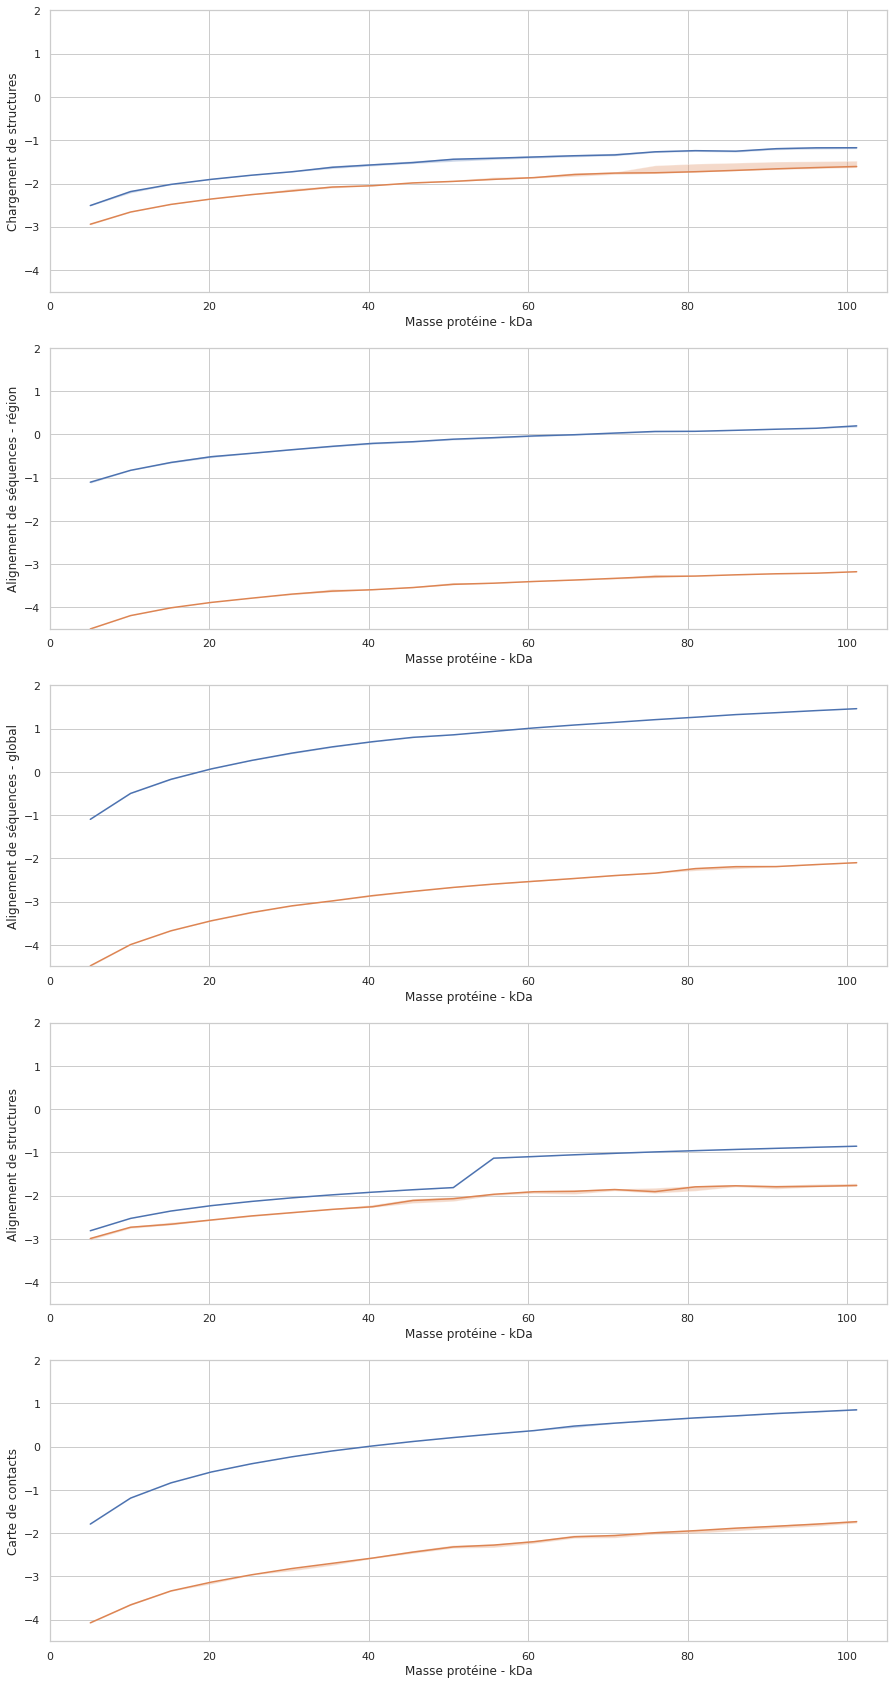

In [69]:
def plot_benchmark(data_python, data_julia):
    keys = data_python.columns[1:]  # Exclure Residues
    
    # Générer les données pour le plot - centile 2.5%, 50% (médiane) & 97.5%
    data = {
        'Python': data_python.groupby(['Masse protéine - kDa']).agg([percentile(25), percentile(50), percentile(75)]),
        'Julia': data_julia.groupby(['Masse protéine - kDa']).agg([percentile(25), percentile(50), percentile(75)])
    }
        
    # Set up plot
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(5, figsize=(15,30))
     
    # Y ax
    y_ax = ['Chargement de structures', 'Alignement de séquences - région', 'Alignement de séquences - global',
           'Alignement de structures', 'Carte de contacts']
        
    for i, key in enumerate(keys):
                
        for k, value in data.items():
             
            # Données
            medians = value[(key, 'centile 50%')]
            centile1, centile2 = value[(key, 'centile 25%')], value[(key, 'centile 75%')]
            medians.name = y_ax[i]
                    
            # Plot
            ax = sns.lineplot(x=value.index, y=medians, ax=axs[i])
            ax.fill_between(x=value.index, y1=centile1, y2=centile2, alpha=0.3)
            
        #ax.axhline(0, ls='dashed')
            
        # Set xaxis & yaxis range
        axs[i].set_ylim(-4.5, 2)
        axs[i].set_xlim(0, 105)
            
    #plt.show()
    plt.savefig("../benchmark-logs_cale")
    
plot_benchmark(data_python, data_julia)